<a href="https://colab.research.google.com/github/TYH71/DELE_CA1/blob/main/Part%20A/1.%20Baseline%20Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST - Basic CNN Implementation

- Name: Tan Yu Hoe
- Admin No: P2026309
- Class: DAAA/FT/2B/04

## Background Information

<img src="https://imgur.com/fPx3dl0.gif" width=700>

Fashion-MNIST is a dataset of Zalando's (German multi national E-commerce company) article images - consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each image is a `28x28 grayscale image`, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in repalcement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.


## Define the Prediction Task

> The objective is to make an image classifier using a deep learning neural network, particularly a CNN, to make predictions for Fashion-MNIST dataset. There are a total of 10 labels in the datasets, making this prediction task a multi-class image classification task.

## Personal Objectives

These are objectives / goals for myself to accomplish while attempting to perform image classification for the Fashion MNIST dataset.

1. Obtain a high test accuracy compared to public benchmark (The average benchmark for Fashon MNIST is about 90% Test Accuracy)
2. Experiment with multiple training strategies and CNN architectures


In [19]:
# import relevant libraries/classes/dependencies
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import datetime
!pip install -q pytz
import pytz
sg = pytz.timezone("Singapore")

# Set the random seeds - to ensure reproducibility
os.environ['TF_CUDNN_DETERMINISTIC'] = "1"
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [20]:
# Matplotlib Stylings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.autolayout'] = True
plt.style.use('fivethirtyeight')

## Setting up **Weights and Biases**

> Weights and Biases: A platform for machine learning practitioner, with a novelty feature of experiment tracking to see machine learning model's performances of different versionings.

[Weights and Biases](https://wandb.ai/site)


In [21]:
# install and configure weights and biases
!pip install -q wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Training on a Tesla P100-PCIE-16GB

There are quite a lot of limitation of using my `NVIDIA GeForce GTX 1050` to trian the model, in terms of training time. Due to my insufficient hardware capability, I decided to switch over to Google Colab where there is a `Tesla P100` available for me, which provided me the resources to train a deeper neural network.

! Important Note: Make sure that you have Tensorflow-GPU, CUDA, and cuDNN enabled before running this notebook.

```bash
pip install tensorflow-gpu
```

In [22]:
!nvidia-smi

Mon Nov 22 03:27:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   4855MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
# Checking if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3226869960889151458
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17873414170627119344
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


## Metadata

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. 

| Labels | Description | Labels | Description |
| --- | --- | --- | --- |
| 0 | T-shirt/top | 5 | Sandal |
| 1 | Trouser | 6 | Shirt
| 2 | Pullover | 7 | Shirt |
| 3 | Dress | 8 | Bag |
| 4 | Coat | 9 | Ankle Boots |

### Acknowledgements

- Original dataset was from https://github.com/zalandoresearch/fashion-mnist

### License

The MIT License (MIT) Copyright © 2017 Zalando SE, [https://tech.zalando.com](https://tech.zalando.com)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [24]:
# Import Dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', "Coat", "Sandle", 'Shirt', 'Sneaker', 'Bag', 'Ankle Boots']
print('Dataset Loaded')

Dataset Loaded


## Exploratory Data Analysis

Before embarking on the image classification task, we will take some titme to explore the data, to gain a better understanding of dataset.

### Questions

Some guiding questions throughout the EDA process, to gain some direction while exploraing the dataset.

- How many observations are there in the data?
- What is the size of the image?
- Does the image match with the given label?
- Is there any abnormalities with the class distribution in the training dataset?


In [25]:
# Shape of Training and Testing Sets
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (60000, 28, 28) y_train: (60000,)
X_test: (10000, 28, 28) y_test: (10000,)


- 60,000 training examples, 10,000 test examples

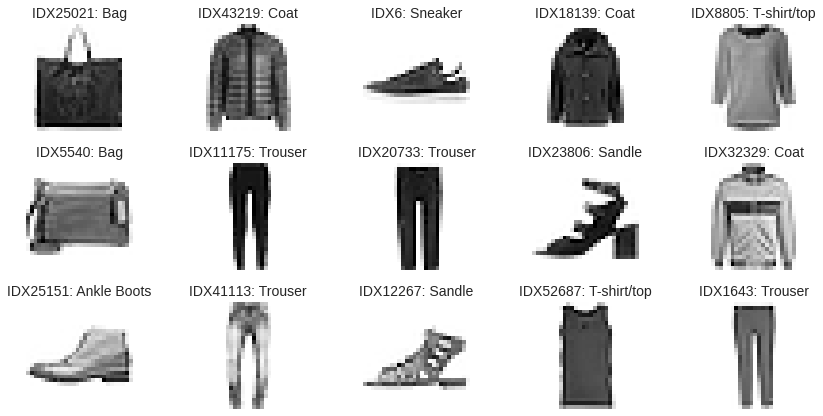

In [26]:
# Randomly display 15 images from the training set
with plt.style.context('seaborn-dark'):
    fig = plt.figure(figsize=(12, 6), tight_layout=True)
    for i in range(1, 16):
        # randomly select an index
        rand_idx = int(np.random.random() * len(X_train))
        
        # creating images
        ax = fig.add_subplot(3, 5, i)
        ax.imshow(X_train[rand_idx])
        ax.set_title(f'IDX{rand_idx}: {classes[y_train[rand_idx]]}', fontsize=14)
        ax.axis('off')

    plt.show()

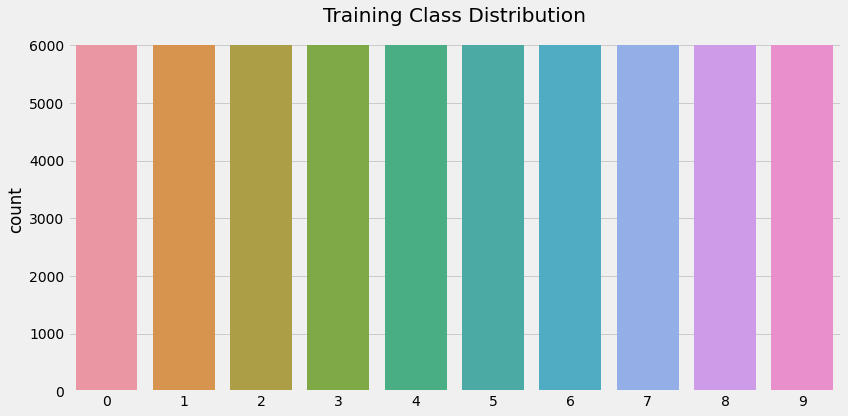

In [27]:
# Class Distribution
sns.countplot(x=y_train).set_title('Training Class Distribution')
plt.show()

## Feature Engineering

> Essentially, this section is purposed for preparing the data before feeding the data into the model.

- `Reshape Input Image` and `Grayscale Conversion to RGB`

For some reason, the Convolution Layer (`tf.keras.layers.Conv2D`) in the Keras API are unable to take in 3D tensors as they account for the RGB Colour Channels. Since our dataset came as a set of greyscale images, which requires to be reshaped from a 3D tensor `(None, 28, 28)` to a 4D tensors `(None, 28, 28, 1)`. Furthermore, nowsadays Keras API and Modern Architectures supports mostly RGB images, which is the main reason why I decided to convert the grayscale images to RGB `(None, 28, 28, 3)` to avoid any problem.

- `Pixel Normalisation / Rescaling`

The purpose of normalisation in image processing is to "attempt" to bring the pixels down to a normal distribution $N(0, 1)$, mitigate the strong influence of very large or very small pixels. Here, I attempt to use a similar concept to `Min-Max Normalisation` (also called `Unity-Based Normalisation`) but bring the pixel intensity values between range [-1, 1]. This is a necessary preprocessing step to improve better optimization within the neural network.

$$ {X}' = a + \frac{(X - X_{min})(b - a)}{X_{max} - X_{min}} = -1 + \frac{(X - 0)(1 - (-1))}{255 - 0} = -1 + \frac{X}{127.5} $$

where $X$ is the pixel intensity value, $b$ is the upper bound of the pre-defined range, $a$ is the lower bound of the pre-defined range.


In [28]:
# Import Keras Functions
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import plot_model
from tensorflow.nn import local_response_normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [29]:
def preprocessing_func(x, y):
    # preprocess X
    x = x.reshape((-1, 28, 28, 1))
    x = tf.cast(x, tf.float32)
    x = tf.image.grayscale_to_rgb(x)
    x = Rescaling(1./127.5, offset=-1)(x)

    return x, y

# transform 
X_train, y_train = preprocessing_func(X_train, y_train)
X_test, y_test = preprocessing_func(X_test, y_test)

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)


Training Shape: (60000, 28, 28, 3) (60000,)
Testing Shape: (10000, 28, 28, 3) (10000,)


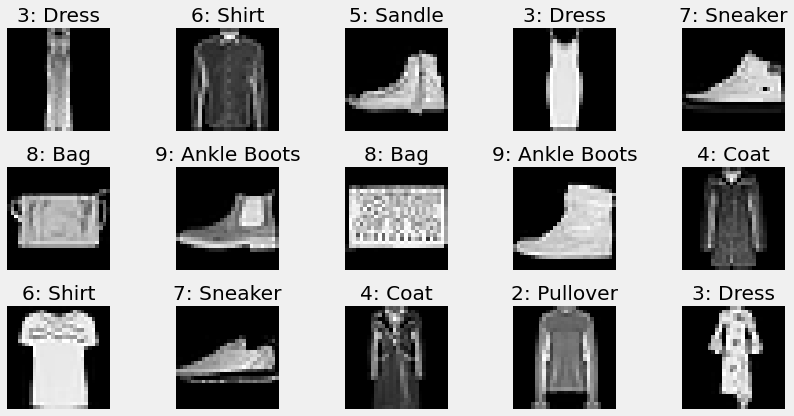

In [30]:
# prepare ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    validation_split=0.1
)

example_ds = train_datagen.flow(x=X_train, y=y_train)
fig = plt.figure()
for i in range(15):
    img, label = example_ds.next()
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow((img[0] + 1) / 2)
    ax.set_title(f"{label[0]}: {classes[label[0]]}")
    ax.axis('off')
plt.show()

## Implementing a Baseline ConvNet

|![](https://imgur.com/9iB8Nrf.png)|
|:--:|
|Illustration of a Convolution Neural Network|

The main purpose of this section of the notebook is to lay out a basic fundamental sequence and to see the performance of a baseline model.

### The Sequence

- `Input Layer and Feature Engineering`
- `Convolution Block`
- `Flatten`

Flatten any input representation into a 1D vector for the hidden dense layers to infer from.

|![](https://i.imgur.com/QbMYuK7.gif)|
|:--:|
|Illustration of the Flatten Process|

- `Dense Blocks`
- `Output Layer`

A single dense layer with `softmax` activation function, purposed for multi-class classification.

- `Compile the model` 

- Adam (Adaptive Momentum) Optimizer to minimize the loss function in the NN. 
- Sparse Categorical Cross-entropy loss (aka logarithmic loss) as a pre-defined loss function to minimise, usually used for multi-class classification tasks. 

> More details to be written in later parts of the notebook for missing points of explanations.


### Convolution Block 

- `Convolution Layer`: 

|![](https://miro.medium.com/max/700/1*D6iRfzDkz-sEzyjYoVZ73w.gif)|
|:--:|
|Illustration of the Convolution Process|

At the heart of the convolutional layer is the convolution operation. In this phase, we make use of what is known as a **kernel** or **filter**, which are convolved with the image. The kernel is basically a matrix of weights that is a trainable parameters in our model. For each image, the convolution operation works by extracting multiple patches of pixels (e.g. 3x3 Grid) from the image to perform element-wise multiplication with the kernel. The output of the convolution process is called as the feature map.

|![](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/28113904/activation-map.png)|
|:--:|
|Illustration of Convolution Layer Output|

Each filter would produce a feature map; eventually, the output from the each filter is stacked together forming the depth dimension of the convolved image.

After building the feature maps, the convolution layer would continue to pass the feature map through an activation function. Here in this case, I used a non-saturating activation function `Rectified Linear Unit` in order to capture non-linearities in the feature map. (also known as representation learning)

$$ \begin{split}R(z) = \begin{Bmatrix} z & z > 0 \\
 0 & z \leq 0 \end{Bmatrix} = max(0, z)\end{split}$$

```python
def relu(z):
  return max(0, z)
```

One thing to point out, I used `He Normal` weights initialization as Kaiming He suggested that Xavier/Glorot weights initializer are not appropriate for `ReLU` activation as they assume the activation function to be linear. A proposition to use `He Initialization`, which is a slight modification to the Xavier initialization. [2]

- `Batch Normalization`

Batch Norm reduces the amount of shifts of distribution for hidden unit values, no matter how the values from previous unit shifts. Batch normalisation is scaled by the mean/variance of the mini-batch, which adds some noise to the values $z$; thus having some regularization effect.

$$ \mu_{Batch} \leftarrow \frac{1}{m}\sum^m_{i=1}{x_i}$$

<br>

$$ \sigma^2_{Batch} \leftarrow \frac{1}{m}\sum^m_{i=1}{(x_i - \mu_{Batch})^2} $$

<br>

$$ \hat{x}_i \leftarrow \frac{x_i - \mu_{Batch}}{\sqrt{\sigma_{Batch}^2 + \epsilon}} $$

<br>

$$ y_i \leftarrow \gamma\hat{x}_i + \beta $$

$\gamma$ and $\beta$ are introduced as trainable parameters to scale and shift the normalized mini-batch output.

- `Max Pooling`

Why Pooling is required? Since images contains large number of pixels, there would be a huge increase of number of weights in the Network, making the backpropagation process computationally expensive. With pooling, we can reduce the number of trainable parameters.

The objective is to downsample the 2D input feature map (created from the convolution process); by downsampling, it means to reduce the spatial size of the image and is implemented on each independent depth dimension. 
we would need to reduce the number of trainable parameters. Max Pooling is the most popular form of pooling layer. 

---

- [2] K. He, X. Zhang, S. Ren, en J. Sun, “Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification”, arXiv [cs.CV]. 2015.

In [31]:
def conv_block(neurons: int, num: int):
    '''
    Creates a generic Hidden Conv2D Layer with ReLU Activations
    Including Batch Normalization and Max Pooling Layers
    
    Args:
        - neurons: number of neurons in the dense layer
        - num    : block number
        - kernel size: height and width of Convolution 2D window (k, k)
          - default: 3
    '''
    block = Sequential(name=f'Covolution_Block_{num}')
    block.add(Conv2D(neurons, kernel_size=(3, 3),
                     activation='relu', strides=1, padding='same', kernel_initializer='he_normal'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    return block


### Fully Connected Block

- `Dense Layer`

A layer of neurons, densely connected to the preceding layer . `ReLU` activation function to induce non-linearity, in order to capture non-linear representation, aka representation learning. In terms of training time, saturating non-linearities, $f(x) = tanh(x)$ or $f(x) = (1 + \epsilon^{-x})$, are much slower than non-saturating nonlinearty. As such, using `ReLU` would be the go to activation function for the entire network architecture.

$$ \begin{split}R(z) = \begin{Bmatrix} z & z > 0 \\ 0 & z <= 0 \end{Bmatrix}\end{split} = max(0, z)$$

```python
def relu(z):
  return max(0, z)
```

One thing to point out, I used `He Normal` weights initialization as Kaiming He suggested that Xavier/Glorot weights initializer are not appropriate for `ReLU` activation as they assume the activation function to be linear. A proposition to use `He Initialization`, which is a slight modification to the Xavier initialization.

- `Dropout`

Randomy setting the weights in the layer to 0 at each update of the training process, a technique to prevent the neural network from overfitting.

At every training iteration, the every neuron has a probability to be dropped out. This means that the neuron will be entirely ignored for the entire training iteration, but might be active in the next training iteration. 

Using Dropout is fairly common regularization technique, which could be seen in most state of the art network architectures to counter overfitting and provide a small accuracy boost.

- `Batch Normalization`

Batch Norm reduces the amount of shifts of distribution for hidden unit values, no matter how the values from previous unit shifts. Batch normalisation is scaled by the mean/variance of the mini-batch, which adds some noise to the values $z$; thus having some regularization effect.

$$ \mu_{Batch} \leftarrow \frac{1}{m}\sum^m_{i=1}{x_i}$$

<br>

$$ \sigma^2_{Batch} \leftarrow \frac{1}{m}\sum^m_{i=1}{(x_i - \mu_{Batch})^2} $$

<br>

$$ \hat{x}_i \leftarrow \frac{x_i - \mu_{Batch}}{\sqrt{\sigma_{Batch}^2 + \epsilon}} $$

<br>

$$ y_i \leftarrow \gamma\hat{x}_i + \beta $$

$\gamma$ and $\beta$ are introduced as trainable parameters to scale and shift the normalized mini-batch output.


In [32]:
# Densely Connected Blocks
def dense_block(neurons: int, num: int, dropout:float):
    '''
    Creates a generic Hidden Dense Layer with ReLU Activations
    Including Dropout and Batch Normalization layers
    
    Args:
        - neurons: number of neurons in the dense layer
        - num    : block number
        - dropout: proportion of weights to apply dropout
    '''
    block = Sequential(name=f'Dense_Block_{num}')
    block.add(Dense(neurons, activation='relu', kernel_initializer='he_normal'))
    block.add(BatchNormalization())
    block.add(Dropout(dropout))

    return block

### Building a Baseline ConvNet

As a baseline, I intend to include only one convolution block and one fully connected block to serve as a baseline model. The end goal is to look for reasonable results on a task without taking much effort and time to build the model.

- `Adam Optimizer`

Adaptive Momentum Optization, often favoured over Stochastic Gradient Descent, as it computes the adaptive learning rates which has a high chance to get out of a local minima.

- `Sparse Categorical Entropy`

This is a multi-class image classification problem (10 classes), I used categorical cross entropy for this task. Since the $Y$ values came as an integer, I use `Sparse Categorical Cross Entropy` as the loss function. Side-note: there is no need to One-Hot encode the labels, as `Sparse Categorical Cross Entropy` will still output the probabilities of each class.

$$ J(w) = -\frac{1}{N} \sum^N_{i=1}{[y_{i}log(\hat{y}_i) + (1 - y_i)log(1 - \hat{y}_i)]} $$



In [33]:
def baseline_builder(input_shape=(28, 28, 3)):
    model = Sequential(name='Baseline')
    
    # Input and Feature Engineering
    model.add(Input(input_shape, name='Input_Layer'))
    
    # Convolutional Block - Feature Extraction
    for layer_num in range(1):
        model.add(conv_block(64, layer_num))
    
    # Flatten Layer - the middle layer between convolutional and densely connected layers
    model.add(Flatten(name='Flatten'))

    # Densely Connected Nodes - Classification Block
    for layer_num in range(1):
        model.add(dense_block(64, layer_num, 0.5))

    # Output Layer - Softmax Activation
    model.add(Dense(10, activation='softmax', name='Softmax_Output_Layer'))
    
    return model

In [34]:
# Intiate Weights and Biases run
current_time = datetime.datetime.now(sg).strftime("%d:%m:%Y_%H:%M")
run = wandb.init(
    project="Fashion MNIST ConvNet",
    name=f"Baseline_ConvNet {[current_time]}",
    config={
        "learning_rate": 0.001,
        "epochs": 50,
        "batch_size": 512,
        "loss_function": "sparse_categorical_crossentropy",
        "architecture": "Baseline ConvNet",
        "dataset": "Fashion MNIST"
    },
    group="Baseline_ConvNet"
)

# Prepare Configurations
config = wandb.config

# Build the Network
tf.keras.backend.clear_session() # Resets all state generated by Keras
baseline = baseline_builder()
baseline.summary()

# Preparing Optimizer
optimizer = Adam(learning_rate=config.learning_rate)

# Compiling - Adam Optimizer Categorical Cross Entropy Loss Function
baseline.compile(
    optimizer=optimizer, 
    loss=config.loss_function, 
    metrics=['accuracy']
)

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Covolution_Block_0 (Sequent  (None, 14, 14, 64)       2048      
 ial)                                                            
                                                                 
 Flatten (Flatten)           (None, 12544)             0         
                                                                 
 Dense_Block_0 (Sequential)  (None, 64)                803136    
                                                                 
 Softmax_Output_Layer (Dense  (None, 10)               650       
 )                                                               
                                                                 
Total params: 805,834
Trainable params: 805,578
Non-trainable params: 256
_________________________________________________________________


In [35]:
# Final Set of Callbacks
callbacks = [
    WandbCallback(save_model=True) # integrated keras callback function by Weights and Biases
]

In [36]:
%%time
# Train Model
baseline_hist = baseline.fit(
      train_datagen.flow(X_train, y_train, subset='training', batch_size=config.batch_size), 
      validation_data=train_datagen.flow(X_train, y_train, subset='validation', batch_size=config.batch_size),
      epochs=config.epochs,
      verbose=1,
      use_multiprocessing=True,
      workers=32,
      callbacks=callbacks
)

Epoch 1/50
106/106 [==============================] - 8s 51ms/step - loss: 0.6279 - accuracy: 0.7931 - val_loss: 0.4616 - val_accuracy: 0.8542
Epoch 2/50
106/106 [==============================] - 7s 49ms/step - loss: 0.4009 - accuracy: 0.8635 - val_loss: 0.4113 - val_accuracy: 0.8695
Epoch 3/50
106/106 [==============================] - 6s 48ms/step - loss: 0.3451 - accuracy: 0.8831 - val_loss: 0.3195 - val_accuracy: 0.8847
Epoch 4/50
106/106 [==============================] - 7s 50ms/step - loss: 0.3083 - accuracy: 0.8940 - val_loss: 0.3010 - val_accuracy: 0.8948
Epoch 5/50
106/106 [==============================] - 7s 48ms/step - loss: 0.2832 - accuracy: 0.9027 - val_loss: 0.2651 - val_accuracy: 0.9052
Epoch 6/50
106/106 [==============================] - 7s 48ms/step - loss: 0.2627 - accuracy: 0.9091 - val_loss: 0.2584 - val_accuracy: 0.9045
Epoch 7/50
106/106 [==============================] - 7s 48ms/step - loss: 0.2467 - accuracy: 0.9137 - val_loss: 0.2680 - val_accuracy: 0.9015

## Baseline Model Evaluation

Why k-fold cross validation is not feasible in neural networks? There are too many data and it is computationally expensive to train a neural network, usually k-fold cross validation is often disregarded when training a neural network.

Here, I just passed the training and testing set in for evaluation, then store the results, log loss and accuracy, in a DataFrame.



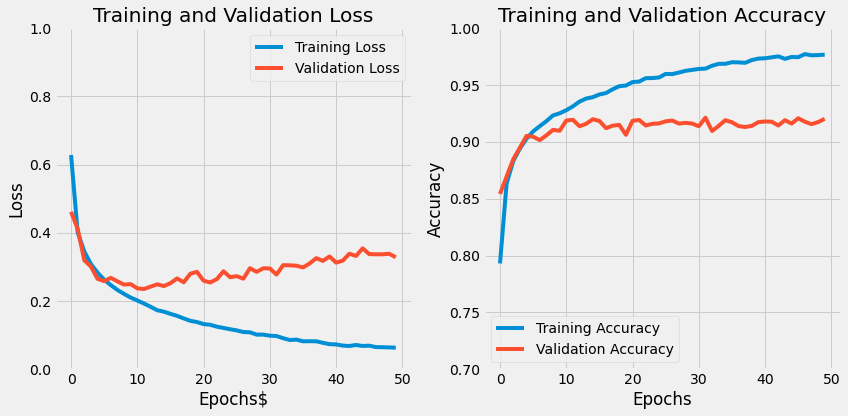

In [37]:
# Plot Learning Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(baseline_hist.history['loss'], label='Training Loss')
ax1.plot(baseline_hist.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs$')
ax1.set_ylabel('Loss')
ax1.set_ylim(bottom=0.0, top=1.0)
ax1.legend()

ax2.plot(baseline_hist.history['accuracy'], label='Training Accuracy')
ax2.plot(baseline_hist.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(top=1.0, bottom=0.7)
ax2.legend()

plt.show()

In [38]:
# Evaluating Training and Testing Set
train = baseline.evaluate(X_train, y_train)
test  = baseline.evaluate(X_test, y_test)

# Creating a Logger to store all Evaluation Results
logger = pd.DataFrame(columns=['Train Loss', 'Train Acc', 'Test Loss', 'Test Acc'])
logger = logger.append(
    pd.Series(
        {
            'Train Loss': train[0],
            'Train Acc' : train[1],
            'Test Loss' : test[0],
            'Test Acc'  : test[1],
            'Test Percentage Error': "{:.2%}".format(1.0 - test[1])
        },
        name='Baseline CovNet',))
logger

313/313 [==============================] - 1s 2ms/step - loss: 0.3567 - accuracy: 0.9138


,Train Loss,Train Acc,Test Loss,Test Acc,Test Percentage Error
Baseline CovNet,0.051767,0.98665,0.356708,0.9138,8.62%


## Making Predictions

For softmax activation in the output layer, it outputs the probabilities of each class for every image. Therefore, Argmax is used to find the arguement that gives the largest probability among the all of the probabilities.

```python
y_pred_class = np.argmax(y_pred, axis=1)
```

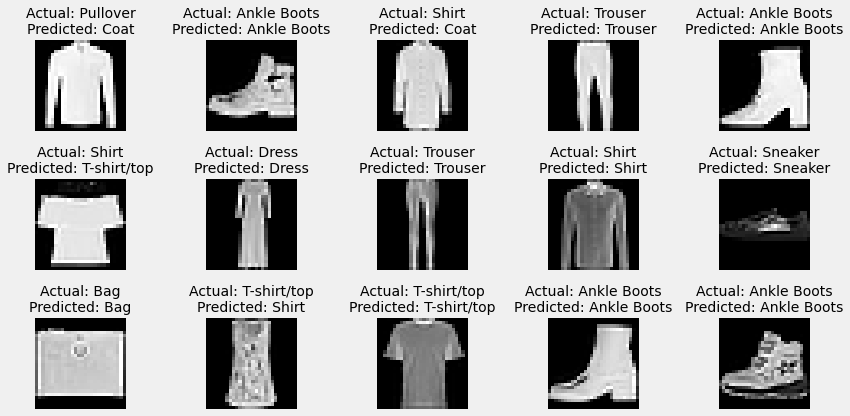

In [39]:
# Predict the values from the test dataset
y_pred = baseline.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_class = np.argmax(y_pred, axis = 1) 

w = 5
h = 3
fig = plt.figure(figsize=(12, 6), tight_layout=True)
for i in range(w*h):
  rand_idx = np.random.randint(0, len(X_test))
  ax = fig.add_subplot(h, w, i+1)
  ax.imshow((X_test[rand_idx] + 1) / 2)
  ax.axis('off')
  ax.set_title(f'Actual: {classes[y_test[rand_idx]]}\nPredicted: {classes[y_pred_class[rand_idx]]}', fontsize=14)
plt.show()


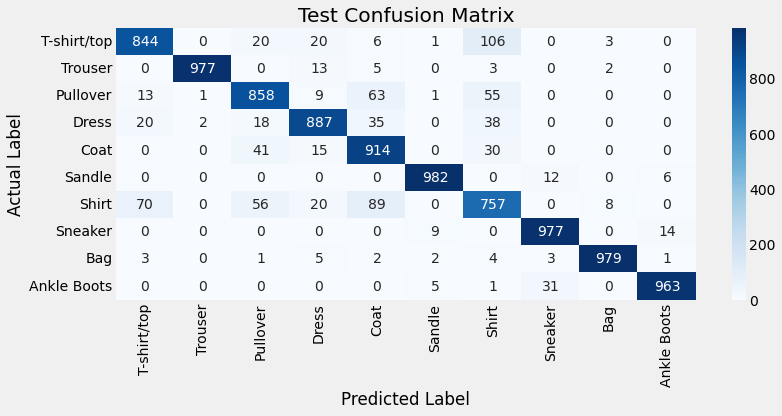

In [40]:
from sklearn.metrics import confusion_matrix
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_class)

sns.heatmap(confusion_mtx, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='.3g')
plt.title('Test Confusion Matrix')
plt.xticks(rotation=90)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [41]:
from sklearn.metrics import classification_report
# print out classification report
print(classification_report(y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.84      0.87      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.86      0.86      0.86      1000
       Dress       0.92      0.89      0.90      1000
        Coat       0.82      0.91      0.86      1000
      Sandle       0.98      0.98      0.98      1000
       Shirt       0.76      0.76      0.76      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.98      0.98      1000
 Ankle Boots       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



## Observations and Further Improvements

- 91.38% test accuracy with major overfitting
- Validation Loss rebounded back as the number of epochs increased, clear indication of a variance problem - overfitting
- Higher confidence in predicting some of the classes (Trousers, Bag, Ankle Boots), while lower confidence in predicting some of the classes (Shirt, Coat, Pullover)
  - notice: better predictions on lower body clothes
- There are too many parameters in the fully connected layers (over 8 million parameters), which leads to longer training time and a larger likelihood to overfitting if wouldn't for the dropout layer.
  - gotta find a way to mitigate the number parameters in the fully connected layer

<br>

- Next focus should be on improving performance to hit a better test accurac (world-record is 96.91%)
- Apply augmentation for more reliable results (corrupting the training data for regularization effect)
- Use better and well known deeper network architectures (eg. ResNet, VGGNet, InceptionNet)
- Perhaps Hyperparameter Tuning to build a deeper network? Not really neccessary and computation inefficient

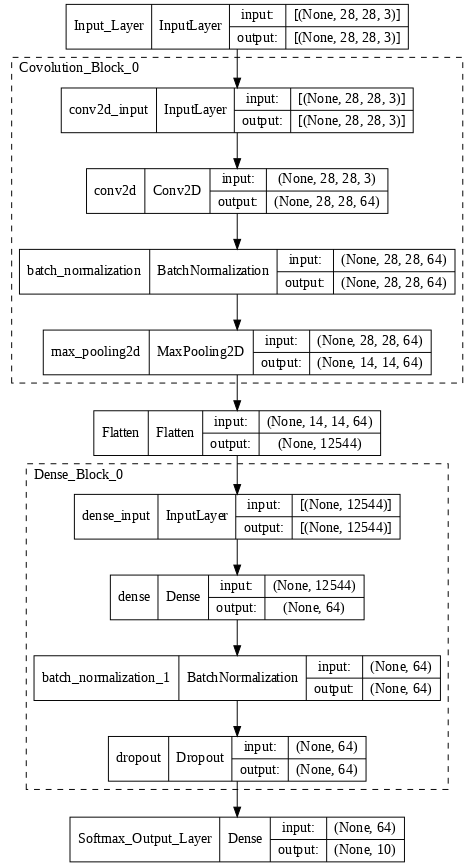

In [42]:
# Display Model Architecture in Notebook Output
from tensorflow.keras.utils import plot_model
plot_model(baseline, show_shapes=True, show_dtype=False,
    show_layer_names=True, expand_nested=True, dpi=70)